# Simulation-Based Inference (SBI) in population genetics

Welcome to this workshop on applying neural posterior estimation (NPE) in population genetics! In this notebook, we will explore together how to use our workflow for simulation-based inference in population genetics. 

## 1. Introduction

We'll walk you through:
1. A brief overview of this project.
2. Exploring pre-simulated data and summary statistics.
3. Posterior sampling using pre-trained NPE networks.
4. Simulating demographic scenarios on your own.
5. Evaluation and visualisations.

### 1.1. A Brief Overview

Neural posterior estimation (NPE) is provided within [sbi toolbox](https://github.com/sbi-dev/sbi) where we can learn the posterior distribution of parameters given observations using flexible neural networks. 
- It allows us to infer complex, high-dimensional parameters without relying on approximate likelihoods.
- The approach is especially useful for scenarios where the likelihood function is expensive or intractable, but data simulation is feasible.
  
You can visit [sbi documentation](https://sbi-dev.github.io/sbi/latest/) for more information.

Based on sbi, our [Snakemake](https://snakemake.readthedocs.io/en/stable/) pipeline provides a framework for simulation-based inference in population genetics using [msprime](https://tskit.dev/msprime/docs/stable/quickstart.html). It automates data simulation (e.g., tree sequences), training of neural posterior estimators (NPEs), and plotting/visualization of inferred parameters. 

### 1.2. Prerequisites

Before we begin, ensure the following:
1. **Operating System**: Linux/macOS/Windows (with WSL or an equivalent environment).
2. **Hardware**:
    - Only CPU is needed for this workshop.
    - [ ] GPU usage will be provided in another Notebook.
3. **Software**:
    - Python 3.9+ [sbi0.22.0](https://github.com/sbi-dev/sbi/releases/tag/v0.22.0).
    - [conda](https://docs.conda.io/en/latest/) (or `venv`) for environment management.
    - Required Python libraries for this tutorial ([requirements](https://github.com/fbaumdicker/ML-PopGen-Tutorials/blob/main/NPEinPopGen/popgensbi.yml)).

#### Environment Setup

To run this notebook, please follow these steps:
1. Install [conda](https://docs.conda.io/en/latest/miniconda.html) if you haven’t already.
2. Clone the repository: `git clone https://github.com/fbaumdicker/ML-PopGen-Tutorials.git` and navigate to the NPEinPopGen directory.
3. Create the environment: `conda env create -f popgensbi.yml`
4. Activate the environment: `conda activate popgensbi`
5. Start notebook kernel: `python -m ipykernel install --user --name popgensbi --display-name "popgensbi"`
6. Launch Jupyter notebook: `jupyter notebook`.
7. In the Notebook, select the "popgensbi" kernel if prompted.

### 1.3. Environment Test

In [15]:
# Are you ready to go?

import sys
import subprocess

# List of critical packages we expect
required_packages = ["msprime", "sbi", "torch"]
missing_packages = []

for pkg in required_packages:
    try:
        __import__(pkg)
    except ImportError:
        missing_packages.append(pkg)

if missing_packages:
    print("WARNING: The following packages are missing:", missing_packages)
    print("Please install or switch to the conda environment that has them.")
else:
    print("All required packages found. Environment looks good!")

All required packages found. Environment looks good!


In [11]:
# Test if NPE is running without problem.
import torch
from sbi.inference import SNPE

# define shifted Gaussian simulator.
def simulator(θ): return θ + torch.randn_like(θ)
# draw parameters from Gaussian prior.
θ = torch.randn(100, 2) #* 10
# simulate data
x = simulator(θ)

# choose sbi method and train
inference = SNPE()
inference.append_simulations(θ, x).train()

posterior = inference.build_posterior()



 Neural network successfully converged after 131 epochs.

In [23]:
# draw from inferred posterior given observed data
#x_o = torch.ones(2)
x_o = torch.as_tensor([1.,-1.])

samples = posterior.sample((1000,), x=x_o)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

### What did we just do?
We trained a neural posterior estimation network that can now generate samples from the posterior distribution very fast.
We then generated 1000 samples from the inferred posterior distribution for an observation [1,-1].
We can visualize this empirical distribution using the function pairplot from sbi

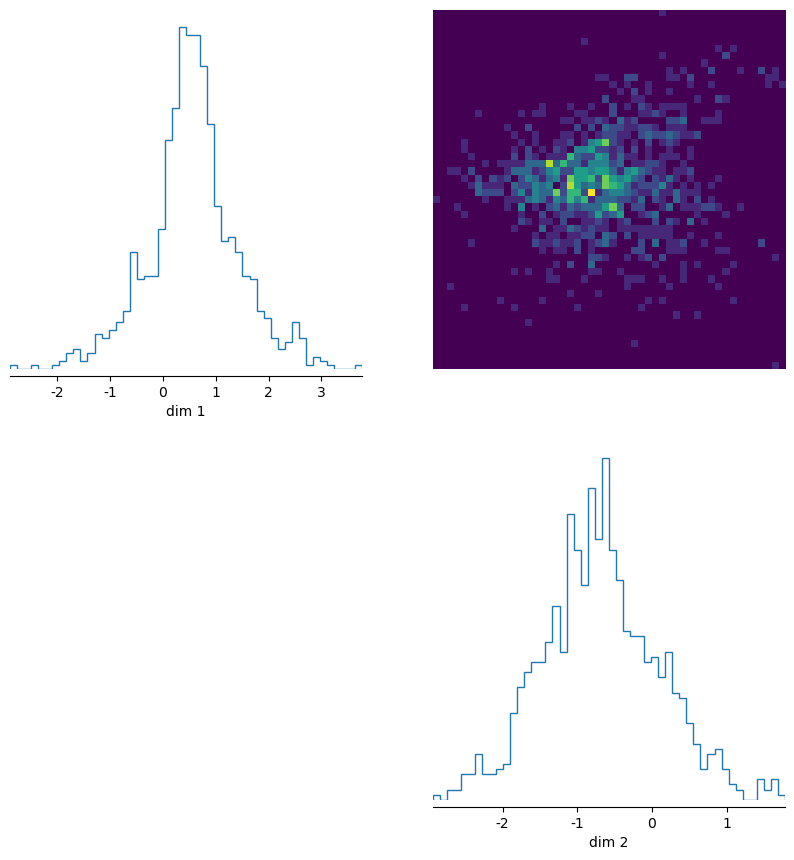

In [24]:
from sbi.analysis import pairplot
_ = pairplot(samples)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

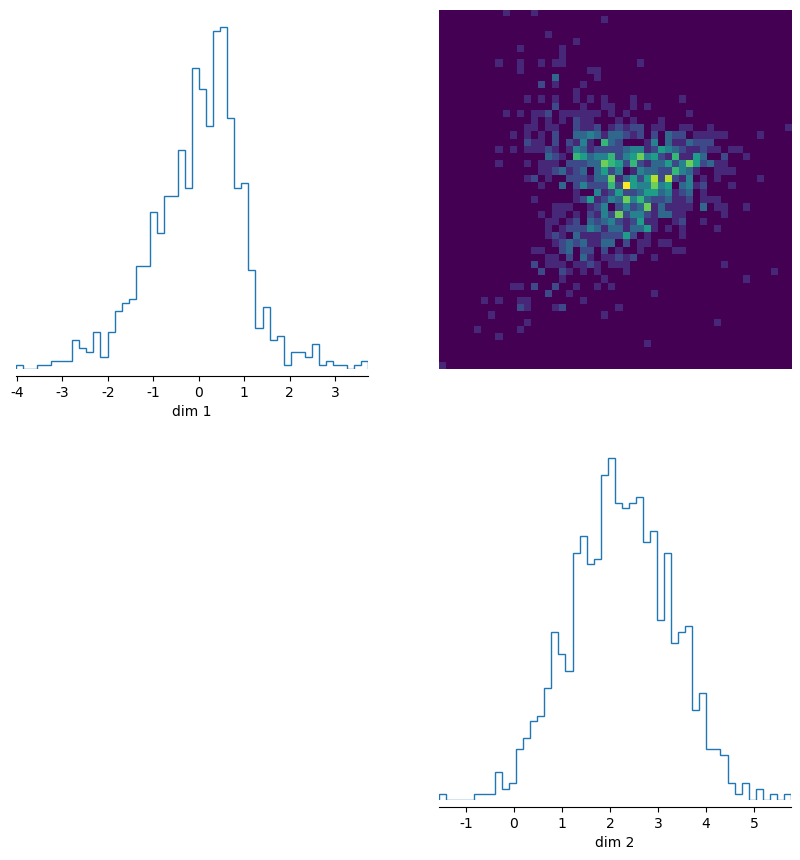

In [25]:
#What happens if we use a different observation?
obs = torch.as_tensor([1.,10.])
samples = posterior.sample((1000,), x=obs)
_ = pairplot(samples)

In [ ]:
# Why is the prediction so bad? Hint: there is an easy way to fix it.

## 2. Explore demographic inference

For sbi we need basically three ingredients: A prior distribution, a simulator that generates data according to the parameters drawn from the prior, and an embedding network or summary statistics extracted from these simulated data. In this section, we first have a look at the parameters and data set. 
All data provided here are from testing sets so that you can test them on a pre-trained neural network to make your own posterior samples.

### 2.1 Simulated data

Through the prior, we randomly generated several independent demographic scenarios. Each scenario has 21 effective population sizes from presence to the past along exponentially growing time steps, and a uniformly distributed fixed global recombination rate.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

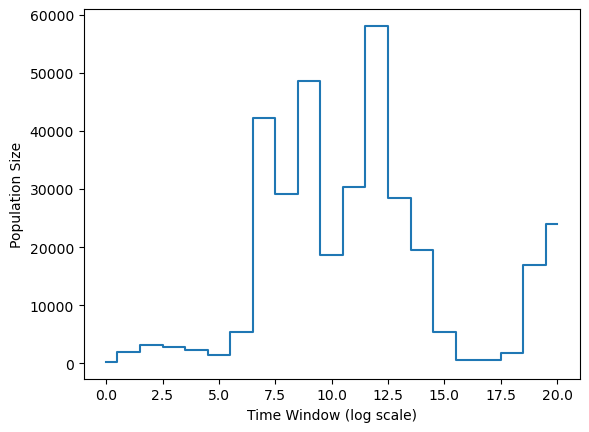

In [28]:
# Here we load a bunch of example scenarios from the test data. 
path_population_sizes = 'sample_data/population_sizes.csv'
df_pop_size = pd.read_csv(path_population_sizes, index_col='scenario', nrows=5)
df_pop_size
# let us look at the first scenario:
scenario_index = 0
sizes = df_pop_size.iloc[scenario_index].iloc[0:21]
plt.step(range(len(sizes)), sizes, where='mid')  # 'mid' ensures steps are centered
plt.xlabel("Time Window (log scale)")
plt.ylabel("Population Size")
plt.show()


#### **Data filtration**
The demographic scenarios have been filtered after simulation by eliminating the ones that generate too few SNPs (in our case < 400). This has already been done here and no code for the filtering is thus shown. However, while this threshold is useful for our application, in general, whether and what threshold you use can be modified based on your research question.

#### **Standardization**
After the filtration, all data sets are standardized using the mean and std of the training data. We also provide a file with the standardized parameters. There will be a de-standardization function in the later part of this notebook. 

Hint: A standardized data set helps with faster convergence, better gradient flow, and more robust performance.

In [29]:
path_std_popsize = 'sample_data/std_test_x.csv'
df_std_pop_size = pd.read_csv(path_std_popsize, index_col='scenario', nrows=5)
df_std_pop_size

,population_size_0,population_size_1,population_size_2,population_size_3,population_size_4,population_size_5,population_size_6,population_size_7,population_size_8,population_size_9,...,population_size_11,population_size_12,population_size_13,population_size_14,population_size_15,population_size_16,population_size_17,population_size_18,population_size_19,population_size_20
scenario,,,,,,,,,,,,,,,,,,,,,
0,-1.992562,-1.004633,-0.836033,-1.062060,-1.295807,-1.856503,-0.815656,0.951254,0.666689,1.085008,...,0.810477,1.215583,0.866869,0.728570,0.187452,-0.723870,-0.738100,-0.134898,0.880484,1.059005
7,0.720528,1.321063,1.321750,0.554317,1.161120,0.068569,0.385149,1.017437,1.479501,1.203457,...,1.086817,1.491056,0.567200,0.142082,0.417316,0.570944,0.045061,-0.287243,-0.135826,-0.992353
10,-1.212919,-0.047562,-1.401544,-1.074045,-1.227387,-0.040657,0.085690,-0.582799,-0.610165,1.067555,...,-0.477949,0.032066,-0.133128,-0.321761,-0.163205,-0.976801,-0.753238,0.289566,1.146259,0.310964
11,0.162120,1.516487,0.457539,-0.350028,0.473978,0.948174,0.356601,0.558883,0.877434,-0.762371,...,0.806376,1.199351,0.828535,-0.238197,0.284750,0.328026,1.354222,0.617826,0.175598,0.615238
17,1.422516,1.494609,1.220774,0.102404,-0.998000,-0.871356,-0.931394,-1.906327,-0.437790,0.946535,...,1.033885,0.131962,0.381469,-0.086240,-0.444833,-0.606437,-1.215719,-0.870220,-1.187812,-1.263719


### 2.2 SNP matrix

[Msprime](https://tskit.dev/msprime/docs/stable/quickstart.html) is a powerful coalescent simulator that models the ancestry of a sample of genomes under specified demographic parameters (e.g., population sizes, mutation rates, recombination rates, and population splits). It generates a [tree sequence](https://tskit.dev/tutorials/intro.html), which is essentially a record of how all sampled individuals coalesce back to their common ancestors. By placing mutations along the branches of these ancestral trees (according to the specified mutation rate), msprime outputs simulated genetic variation—ultimately yielding SNP data or variant matrices that can be used for downstream analyses, such as training neural posterior estimators in our pipeline. Let us load one such SNP matrix together with the SNP positions.

In [30]:
# load SNP matrices
path_SNP = f'sample_data/scenario_{df_std_pop_size.index[0]}_rep_0.npz'
with np.load(path_SNP) as data_npz:
    snp = data_npz['SNP']
    pos = data_npz['POS']

In [31]:
snp
#snp.shape

array([[0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [32]:
pos
# pos.shape

array([ 41, 619,  75, ..., 730, 353, 793])

This is the type of data we are using as the input for our population size inference. Now there are multiple ways how to make this high-dimensional data accessible for the neural posterior estimation network. We need to provide features to the NPE network. These features can be predefined summary statistics based on snp and pos or can be extracted by a neural embedding network. An embedding network can either be pretrained or trained jointly with the NPE network in an end-to-end manner. However, in this workshop, we will stick with using predefined summary statistics.

### 2.3 Summary statistics

We computed **site frequency spectrum** and **linkage disequilibrium** from the SNP matrices and the positions, which ends up into 68 summary statistics. In particular we simulated populations of 50 haploids, such that there are 49 values for the site frequency spectrum which counts how many mutations appear in exactly k haploids. In addition we calculated the mean linkage disequilibrium for pairs of SNPs in 19 different distance bins. The closer the SNPs are located to each other the higher the linkeage disequilibrium typically is.

We will provide networks trained with all 68 summary statistics, only with 49 SFS, and only with 19 LD, respectively in the following sections.

In [33]:
path_summary_statistics = 'sample_data/test_y.csv'
df_sum = pd.read_csv(path_summary_statistics, index_col='scenario', nrows=5)
df_sum

,count_SNP_1,count_SNP_2,count_SNP_3,count_SNP_4,count_SNP_5,count_SNP_6,count_SNP_7,count_SNP_8,count_SNP_9,count_SNP_10,...,"mean_r2_(8157.722, 14142.136]","mean_r2_(14142.136, 24516.649]","mean_r2_(24516.649, 42501.79]","mean_r2_(42501.79, 73680.63]","mean_r2_(73680.63, 127731.92]","mean_r2_(127731.92, 221434.636]","mean_r2_(221434.636, 383876.621]","mean_r2_(383876.621, 665484.238]","mean_r2_(665484.238, 1153676.071]","mean_r2_(1153676.071, 2000000.0]"
scenario,,,,,,,,,,,,,,,,,,,,,
0,191.59,153.08,145.91,124.32,106.27,92.65,85.39,80.69,68.70,61.74,...,0.186863,0.177153,0.161714,0.151360,0.140632,0.125528,0.111245,0.095518,0.084833,0.077355
7,1092.80,483.39,288.83,198.58,148.06,114.44,90.94,76.14,62.84,52.88,...,0.053257,0.045699,0.040724,0.034492,0.029820,0.026047,0.022885,0.021848,0.023914,0.021567
10,173.13,115.78,86.36,62.97,50.10,39.32,35.09,28.41,24.25,21.39,...,0.119060,0.104124,0.091742,0.075124,0.064209,0.057511,0.049248,0.041244,0.036941,0.034100
11,612.59,262.88,154.78,112.21,89.01,73.45,63.73,55.24,48.61,45.32,...,0.086394,0.078134,0.067522,0.057797,0.046161,0.039810,0.032048,0.026052,0.023891,0.025308
17,268.91,123.11,85.78,73.15,62.09,56.29,47.96,42.65,39.76,34.65,...,0.139463,0.129162,0.112718,0.098029,0.077831,0.059201,0.044842,0.034625,0.025633,0.021017


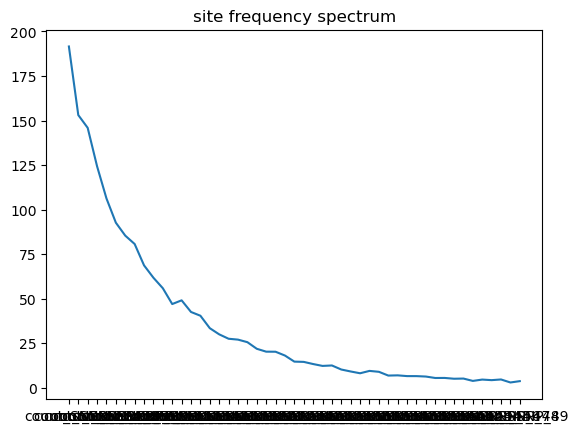

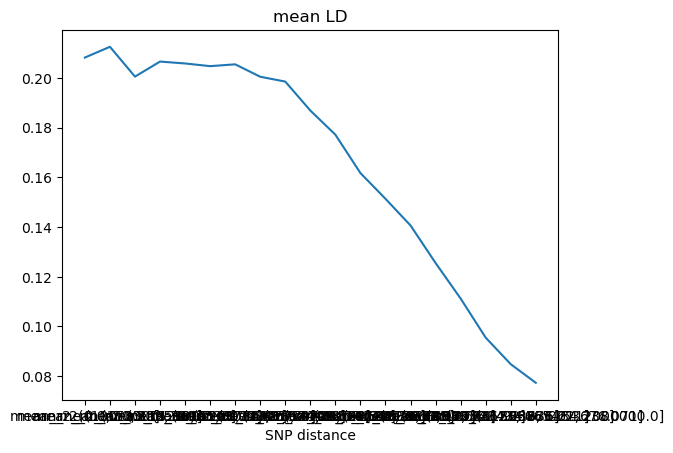

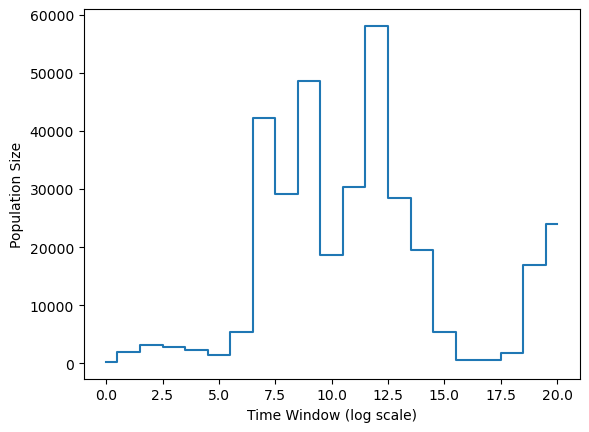

In [34]:
# Let us visualize a few summary statistics alongside the population size parameters
scenario_num = 0
plt.plot(df_sum.iloc[scenario_num][0:49])
plt.title("site frequency spectrum")
plt.show()
plt.plot(df_sum.iloc[scenario_num][49:68])
plt.title("mean LD")
plt.xlabel("SNP distance")
plt.show()
sizes = df_pop_size.iloc[scenario_num].iloc[0:21]
plt.step(range(len(sizes)), sizes, where='mid')  # 'mid' ensures steps are centered
plt.xlabel("Time Window (log scale)")
plt.ylabel("Population Size")
plt.show()

### 2.4 Pre-trained network

We provide here a pretrained NPE network that you can try. Give it a shot!

In [8]:
import pickle
import sys
sys.path.insert(1,'SnakemakePipeline/workflow/scripts/')
import simulatePop

# This network is trained on population sizes and summary statistics. 
posterior_path = 'trained_NN/posterior_AFS_LD.pkl'
with open(posterior_path, 'rb') as f:
    pretrained_posterior = pickle.load(f)

# Now we can do inference with the loaded posterior
test_index = 0
observed_x = df_sum.iloc[test_index]
true_params = df_std_pop_size.iloc[test_index]

inferred_samples = pretrained_posterior.sample((100,), x=observed_x)
inferred_samples

# you can destandardize the samples if you loaded the training mean and std below
#inferred_samples = np.exp(inferred_samples * train_std.numpy() + train_mean.numpy())

NameError: name 'df_sum' is not defined

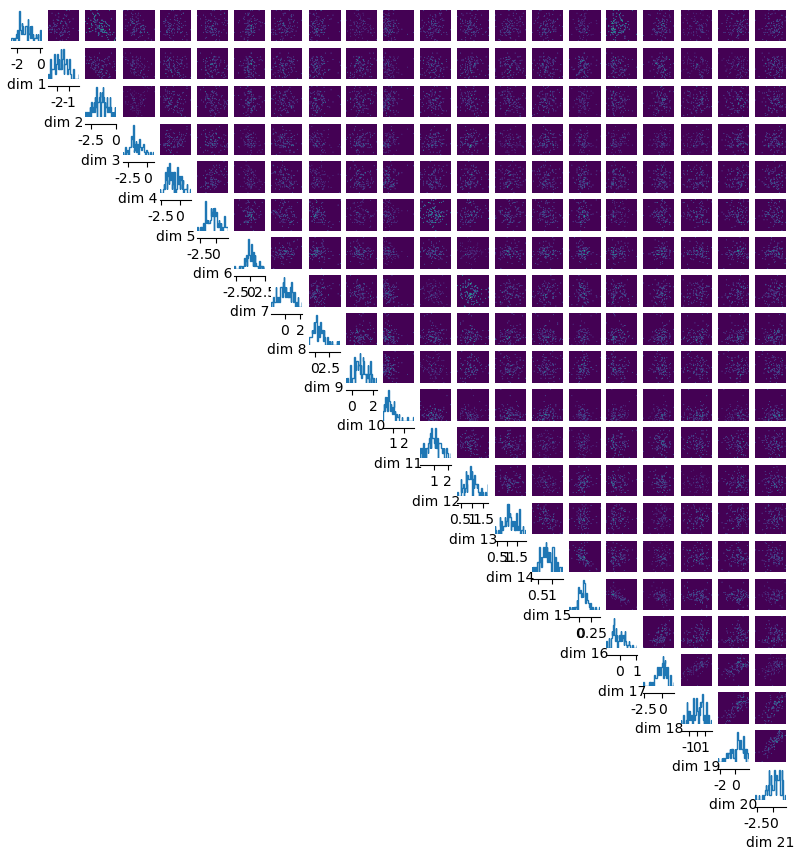

In [36]:
# Ok let's look at the posterior distribution
#inferred_samples.shape
_ = pairplot(inferred_samples)

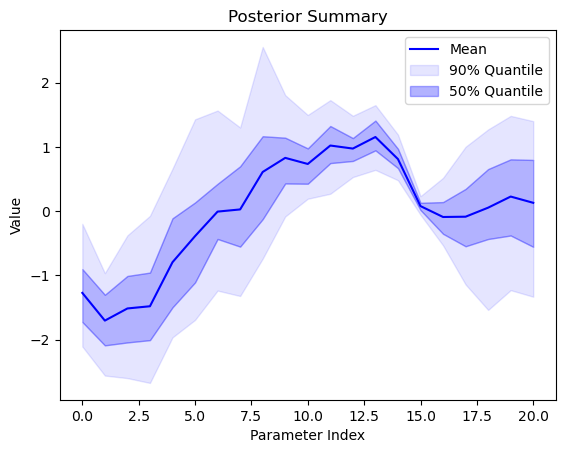

In [39]:
# Maybe this visualization is more insightful
# But keep in mind that we are using standardized population sizes here
# You can find how to destandardize them further below

# Compute summary statistics
mean = inferred_samples.mean(dim=0)  # Mean across samples
q05 = torch.quantile(inferred_samples, 0.05, dim=0)  # 75th percentile
q25 = torch.quantile(inferred_samples, 0.25, dim=0)  # 95th percentile
q75 = torch.quantile(inferred_samples, 0.75, dim=0)  # 75th percentile
q95 = torch.quantile(inferred_samples, 0.95, dim=0)  # 95th percentile

# Plot
x = np.arange(21)  # X-axis: parameter indices
plt.plot(x, mean, label='Mean', color='blue')
plt.fill_between(x, q75, q95, alpha=0.1, color='blue', label='90% Quantile')
plt.fill_between(x, q25, q75, alpha=0.3, color='blue', label='50% Quantile')
plt.fill_between(x, q05, q25, alpha=0.1, color='blue')
plt.xlabel("Parameter Index")
plt.ylabel("Value")
plt.title("Posterior Summary")
plt.legend()
plt.show()


#### Training the neural network is the main part of this project. However, a decent training process could take a few hours. 
Here is an example of how we trained the neural network. You're free to try it out with small data sets. The result is obviously not very convincing.

In [41]:
## This is how the network is trained. This could take some time for larger training data.

from sbi.inference import SNPE, prepare_for_sbi
import torch

# Convert to torch tensors
theta = torch.tensor(pd.read_csv(path_std_popsize, index_col='scenario').values, dtype=torch.float32)
x = torch.tensor(pd.read_csv(path_summary_statistics, index_col='scenario').values, dtype=torch.float32)

# Usually, you'd define a prior or pass a prior object.
# But here we simply feed the already simulated data to sbi
inference = SNPE(prior=None) 

# Train the posterior (this can take a while, especially on CPU)
density_estimator = inference.append_simulations(theta, x).train(show_train_summary=True)
posterior_poor = inference.build_posterior(density_estimator)

 Neural network successfully converged after 138 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 138
        Best validation performance: -18.9917
        -------------------------
        


### 

---

## 3. Various scenarios

A population could go through different types of history. We can specifically simulate them here, and see how the neural network performs on each of them. In this section, you will be simulating the testing data and computing the summary statistics on your own, instead of loading them directly! 

### 3.1 Simulate 6 representative scenarios

- **Medium**: constant population sizes of 5,000.
- **Large**: constant population sizes of 50,000. 
- **Decline**: decreasing population sizes. 
- **Expansion**: increasing population sizes.
- **Bottleneck**: population sizes decrease drastically and increase again.
- **Zigzag**: two bottlenecks in a row.

In [5]:
import msprime

def simulate_scenario(population_size, population_time, seed, num_replicates, mutation_rate, recombination_rate, 
                      segment_length, num_sample):
    
    demography = msprime.Demography()
    demography.add_population(initial_size=population_size[0])

    for i in range(1, len(population_size)):
        demography.add_population_parameters_change(time=population_time[i], initial_size=population_size[i], growth_rate=0)

    ts = msprime.sim_ancestry(
        num_sample,
        random_seed=seed,
        sequence_length=segment_length,
        ploidy=1,
        num_replicates=num_replicates,
        demography=demography,
        recombination_rate=recombination_rate)
    pos = []
    snp = []
    
    for rep, tree in enumerate(ts):
        mts = msprime.sim_mutations(tree, rate=mutation_rate, random_seed=seed)
        positions = [variant.site.position for variant in mts.variants()]
        positions = np.array(positions) - np.array([0] + positions[:-1])
        positions = positions.astype(int)
        pos.append(positions)
        SNPs = mts.genotype_matrix().T.astype(np.uint8)
        snp.append(SNPs)
    
    data = [[snp[i], pos[i]] for i in range(len(snp))]
    data = [np.vstack([d[1], d[0]]) for d in data]
    return data

# Population sizes are defined on a log10 scale
scenarios = {'Medium': [3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7],   
             'Large': 4.7 * np.ones(shape=21, dtype='float'), 
             'Decline': [2.5, 2.5, 3, 3, 3, 3, 3.2, 3.4, 3.6, 3.8, 4, 4.2, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6], 
             'Expansion': [4.7, 4.7, 4.7, 4.6, 4.6, 4.5, 4.4, 4.3, 4, 3.7, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4], 
             'Bottleneck': [4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.5, 4.15, 3.8, 4.3, 4.8, 4.55, 4.3, 4.05, 3.8, 3.8, 3.8, 3.8], 
             'Zigzag': [4.8, 4.8, 4.8, 4.5, 4.15, 3.8, 4.15, 4.5, 4.8, 4.5, 4.15, 3.8, 4.3, 4.8, 4.55, 4.3, 4.05, 3.8, 3.8, 3.8, 3.8]}
# transform them back to normal scale
scenarios = {k:10**np.array(scenarios[k]) for k in scenarios.keys()}

seed = 2
num_replicates = 100
mutation_rate = 1e-8
segment_length = 2e6
time_rate = 0.06
tmax = 130000
num_time_windows = 21
num_sample = 50
population_time = [(np.exp(np.log(1 + time_rate * tmax) * i /
                  (num_time_windows - 1)) - 1) / time_rate for i in
                  range(num_time_windows)]

snp_data = {}
for k in scenarios.keys():
    print(f'Simulating scenario \"{k}\"')
    population_size = scenarios[k]
    recombination_rate = np.random.uniform(low=1e-9, high=1e-8)
    snp_data[k] = simulate_scenario(population_size, population_time, seed, num_replicates, mutation_rate, recombination_rate, segment_length, num_sample)

Simulating scenario "Medium"
Simulating scenario "Large"
Simulating scenario "Decline"
Simulating scenario "Expansion"
Simulating scenario "Bottleneck"
Simulating scenario "Zigzag"


### custom scenarios
you can change the scenarios above to custom scenarios if you wish.

### 3.2 Compute summary statistics

Here we provide functions to calculate the summary statistics (SFS and binned LD) that the neural network has been trained on for the simulated scenarios.

In [3]:
import allel
np.random.seed(42)

def LD(haplotype, pos_vec, size_chr, circular=True, distance_bins=None):
    if distance_bins is None or isinstance(distance_bins, int):
        if isinstance(distance_bins, int):
            n_bins = distance_bins - 1
        else:
            n_bins = 19
        if circular:
            distance_bins = np.logspace(2, np.log10(size_chr // 2), n_bins)
            distance_bins = np.insert(distance_bins, 0, [0])
        else:
            distance_bins = np.logspace(2, np.log10(size_chr), n_bins)
            distance_bins = np.insert(distance_bins, 0, [0])

    # Iterate through gap sizes
    n_SNP, n_samples = haplotype.shape
    gaps = (2 ** np.arange(0, np.log2(n_SNP), 1)).astype(int)

    # Initialize lists to store selected SNP pairs and LD values
    selected_snps = []
    for gap in gaps:
        snps = np.arange(0, n_SNP, gap) + np.random.randint(0, (n_SNP - 1) % gap + 1)
        # adding a random start (+1, bc 2nd bound in randint is exlusive)

        # non overlapping contiguous pairs
        # snps=[ 196, 1220, 2244] becomes
        # snp_pairs=[(196, 1220), (1221, 2245)]
        snp_pairs = np.unique([((snps[i] + i) % n_SNP, (snps[i + 1] + i) % n_SNP) for i in range(len(snps) - 1)],
                              axis=0)

        # If we don't have enough pairs (typically when gap is large), we add a random rotation until we have at
        # least 300) count = 0

        if not circular:
            snp_pairs = snp_pairs[snp_pairs[:, 0] < snp_pairs[:, 1]]
        last_pair = snp_pairs[-1]

        if circular:
            max_value = n_SNP - 1
        else:
            max_value = n_SNP - gap - 1

        while len(snp_pairs) <= min(300, max_value):
            # count += 1 if count % 10 == 0: print(">>  " + str(gap) + " - " + str(len(np.unique(snp_pairs,
            # axis=0))) + " -- "+ str(len(snps) - 1) + "#" + str(count)) remainder = (n_SNP - 1) % gap if (n_SNP - 1)
            # % gap != 0 else (n_SNP - 1) // gap
            random_shift = np.random.randint(1, n_SNP) % n_SNP
            new_pair = (last_pair + random_shift) % n_SNP
            snp_pairs = np.unique(np.concatenate([snp_pairs, new_pair.reshape(1, 2)]), axis=0)
            last_pair = new_pair

            if not circular:
                snp_pairs = snp_pairs[snp_pairs[:, 0] < snp_pairs[:, 1]]

        selected_snps.append(snp_pairs)

    # Functions to aggregate the values within each distance bin
    agg_bins = {"snp_dist": ["mean"], "r2": ["mean", "count", "sem"]}

    ld = pd.DataFrame()
    for i, snps_pos in enumerate(selected_snps):

        if circular:
            sd = pd.DataFrame((np.diff(pos_vec[snps_pos]) % size_chr) % (size_chr // 2),
                              columns=["snp_dist"])  # %size_chr/2 because max distance btw 2 SNP is size_chr/2
        else:
            sd = pd.DataFrame((np.diff(pos_vec[snps_pos])), columns=["snp_dist"])

        sd["dist_group"] = pd.cut(sd.snp_dist, bins=distance_bins)
        sr = [allel.rogers_huff_r(snps) ** 2 for snps in haplotype[snps_pos]]
        sd["r2"] = sr
        sd["gap_id"] = i
        ld = pd.concat([ld, sd])

    ld2 = ld.dropna().groupby("dist_group",observed=True).agg(agg_bins)

    # Flatten the MultiIndex columns and rename explicitly
    ld2.columns = ['_'.join(col).strip() for col in ld2.columns.values]
    ld2 = ld2.rename(columns={
        'snp_dist_mean': 'mean_dist',
        'r2_mean': 'mean_r2',
        'r2_count': 'Count',
        'r2_sem': 'sem_r2'
    })
    # ld2 = ld2.fillna(-1)
    return ld2[['mean_r2']]


def sfs(haplotype, ac):
    """
    Calculate the site frequency spectrum (SFS) from haplotype data and allele counts.

    Parameters
    ----------
    haplotype (numpy.ndarray): The haplotype matrix where rows represent variants and columns represent individuals.
    ac (numpy.ndarray): Allele count array where each entry represents the count of the derived allele at a site.

    Returns
    -------
    pandas.DataFrame: DataFrame containing the SFS. Each row corresponds to a frequency (number of individuals),
    with the corresponding count of SNPs that have that frequency.

    """
    nindiv = haplotype.shape[1]
    tmp_df = pd.DataFrame({"N_indiv": range(1, nindiv)})

    # getting unfolded sfs
    df_sfs = pd.DataFrame(allel.sfs(ac.T[1]), columns=["count_SNP"])
    df_sfs.index.name = "N_indiv"
    df_sfs.reset_index(inplace=True)
    df_sfs = df_sfs.merge(tmp_df, on="N_indiv", how="right").fillna(0).astype(int)

    return df_sfs

def compute_sumstat(snp_data):
    output=[]
    scenario_data = {}
    for scenario in snp_data:
        for rep in snp_data[scenario]:
            snp = rep[1:]
            pos = rep[0]

            if any(np.diff(pos) < 0):
                pos = np.cumsum(pos)
            if pos.max() <= 1:
                pos = (pos * 2e6).round().astype(int)

            haplotype = allel.HaplotypeArray(snp.T)
            allel_count = haplotype.count_alleles()
        
            afs = sfs(haplotype, allel_count)
            afs = afs.set_index('N_indiv')
            afs['scenario'] = scenario

            ld = LD(haplotype, pos, circular=False, size_chr=2e6)
            ld["scenario"] = scenario
#             ld = ld.drop(columns=['sem_r2'])

            if scenario not in scenario_data:
                scenario_data[scenario] = {"afs": [], "ld": []}
            scenario_data[scenario]["afs"].append(afs)
            scenario_data[scenario]["ld"].append(ld)

    for scenario in snp_data:
        mean_afs = pd.concat(scenario_data[scenario]["afs"]).groupby("N_indiv",observed=True).mean(numeric_only=True)
        mean_afs['scenario'] = scenario
        mean_afs.reset_index(inplace=True)
        mean_ld = pd.concat(scenario_data[scenario]["ld"]).groupby("dist_group",observed=True).mean(numeric_only=True)
        mean_ld['scenario']=scenario
        mean_ld.reset_index(inplace=True)
        
        df_sfs = mean_afs.set_index('N_indiv')
        df_sfs_out = df_sfs.loc[df_sfs['scenario'] == scenario]
        df_sfs_out = df_sfs_out.drop(columns=['scenario'])
        df_sfs_out = df_sfs_out.stack(future_stack=True)
        df_sfs_out.index = df_sfs_out.index.map('{0[1]}_{0[0]}'.format)
        df_sfs_out = df_sfs_out.to_frame().T
        df_sfs_out = df_sfs_out.set_index([[scenario]])

        df_ld_out = mean_ld.loc[np.array(mean_ld['scenario'] == scenario)]
        df_ld_out = df_ld_out.drop(columns=['scenario'])
        df_ld_out = df_ld_out.stack(future_stack=True)
        df_ld_out.index = df_ld_out.index.map('{0[1]}_{0[0]}'.format)
        df_ld_out = df_ld_out.to_frame().T
        df_ld_out = df_ld_out.set_index([[scenario]])
        df = pd.merge(df_sfs_out, df_ld_out, left_index=True, right_index=True)
        output.append(df)
    return output

#computing the summary statistics will take some time!

In [6]:
sumstats=compute_sumstat(snp_data)
tt = pd.DataFrame()
for v in sumstats:
    tt = pd.concat([tt,v])
sumstats = tt.drop(columns=[c for c in tt.columns if c.startswith('mean_dist') or c.startswith('dist') or c.startswith('Count_')])
sumstats.index.name='scenario'

sumstats

,count_SNP_1,count_SNP_2,count_SNP_3,count_SNP_4,count_SNP_5,count_SNP_6,count_SNP_7,count_SNP_8,count_SNP_9,count_SNP_10,...,mean_r2_9,mean_r2_10,mean_r2_11,mean_r2_12,mean_r2_13,mean_r2_14,mean_r2_15,mean_r2_16,mean_r2_17,mean_r2_18
scenario,,,,,,,,,,,,,,,,,,,,,
Medium,189.73,98.13,64.27,47.31,38.18,32.78,27.32,23.69,20.44,20.20,...,0.160222,0.148264,0.131957,0.108238,0.087699,0.069372,0.053128,0.041808,0.031738,0.030023
Large,1963.34,991.23,663.07,500.34,397.91,333.16,279.94,246.37,220.88,203.07,...,0.058061,0.046584,0.038641,0.030912,0.026462,0.024822,0.023193,0.022433,0.021261,0.02101
Decline,85.96,69.71,77.25,66.18,62.37,59.24,55.72,62.66,60.02,51.14,...,0.521771,0.473272,0.423072,0.363841,0.303251,0.240218,0.186958,0.144177,0.113298,0.081049
Expansion,538.73,145.08,67.45,43.48,28.28,22.90,17.89,14.42,12.67,10.76,...,0.054565,0.047294,0.042316,0.036381,0.029952,0.028088,0.023847,0.022421,0.02131,0.022004
Bottleneck,1170.31,376.26,209.81,147.25,117.71,101.31,90.44,79.07,75.86,67.35,...,0.102019,0.092865,0.077872,0.0627,0.04932,0.037201,0.027172,0.023921,0.021401,0.023064
Zigzag,701.77,327.31,226.34,160.80,131.15,107.50,97.47,83.49,75.15,65.06,...,0.135048,0.120712,0.103036,0.084995,0.067638,0.049505,0.037368,0.032002,0.02979,0.025739


In [ ]:
# Just in case the computation didn't work out

# sumstats = pd.read_csv('sample_data/Demo_sumstat.csv', index_col='scenario')
# sumstats

In [9]:
samples = pretrained_posterior.sample((100,), x=sumstats.loc['Medium'])

/home/franz/miniconda3/envs/popgensbi/lib/python3.9/site-packages/sbi/utils/user_input_checks.py:584: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = atleast_2d(torch.as_tensor(x, dtype=float32))


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

---

So far we have walked through the complete workflow including data simulation and NPE training. 
There are different ways to visualize the posterior distribution using sbi integrated, or self-defined functions.


## 4. Evaluation and visualisation

This is a free section! Apart from some functions provided here, please try visualize the results by yourself.

In [12]:
# Unstandardize the predicted values
import json

with open('sample_data/training_param.json', 'r') as file:
    train_param = json.load(file)
train_mean = torch.Tensor(list(train_param['train_mean'].values()))
train_std = torch.Tensor(list(train_param['train_std'].values()))

In [13]:
population_time_demo = [(np.exp(np.log(1 + time_rate * tmax) * i /
                  (num_time_windows-1)) - 1) / time_rate for i in
                  range(num_time_windows+1)]

#sns.set(style="white", font_scale=1.2)
def pred_with_CI(ax, population_time, demo_param, samples):
    demo_param = np.append(demo_param, demo_param[-1])
    samples = np.insert(samples,-1, samples[:,-1], axis=1)
    
    #means = samples.mean(0)
    medians = samples.median(0)[0]
    lower_bound = np.percentile(samples, 2.5, axis=0)
    upper_bound = np.percentile(samples, 97.5, axis=0)

    lower_bound_50 = np.percentile(samples, 25, axis=0)
    upper_bound_50 = np.percentile(samples, 75, axis=0)
    
    ax.fill_between(population_time, lower_bound, upper_bound, step='post', color='blue', alpha=0.15,
                     label='95% Confidence Interval')
    ax.fill_between(population_time, lower_bound_50, upper_bound_50, step='post', color='blue', alpha=0.2,
                     label='50% Confidence Interval')
    ax.set_xscale('log')
    #ax.step(population_time, means, where='post', label='NPE_samples_mean', color='blue')
    ax.step(population_time, medians, where='post', label='NPE_samples_median', color='blue')
    ax.step(population_time, demo_param, where='post',
             label='Population Size', linestyle='--', color='black')
    ax.set_yscale('log')
    ax.grid(True)

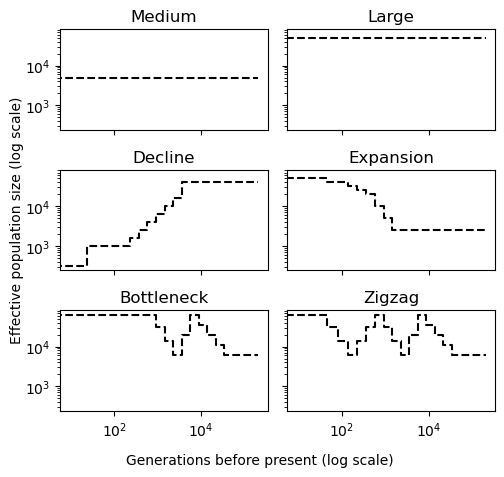

In [20]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(5, 5), sharex=True, sharey=True)
axs = axs.flatten()

for i, (ax, sce) in enumerate(zip(axs, scenarios)):

    demo_param = np.append(scenarios[sce], scenarios[sce][-1])

    ax.step(population_time_demo, demo_param, where='post', label='Population Size', linestyle='--', color='black')
    ax.set_yscale('log')
    #ax.grid(True)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(sce)
fig.text(0.5, 0.01, 'Generations before present (log scale)', ha='center')
fig.text(0.0001, 0.5, 'Effective population size (log scale)', va='center', rotation='vertical')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the legend and labels
plt.show()

/home/franz/miniconda3/envs/popgensbi/lib/python3.9/site-packages/sbi/utils/user_input_checks.py:584: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = atleast_2d(torch.as_tensor(x, dtype=float32))


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_40106/3150701556.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,max_population_time)


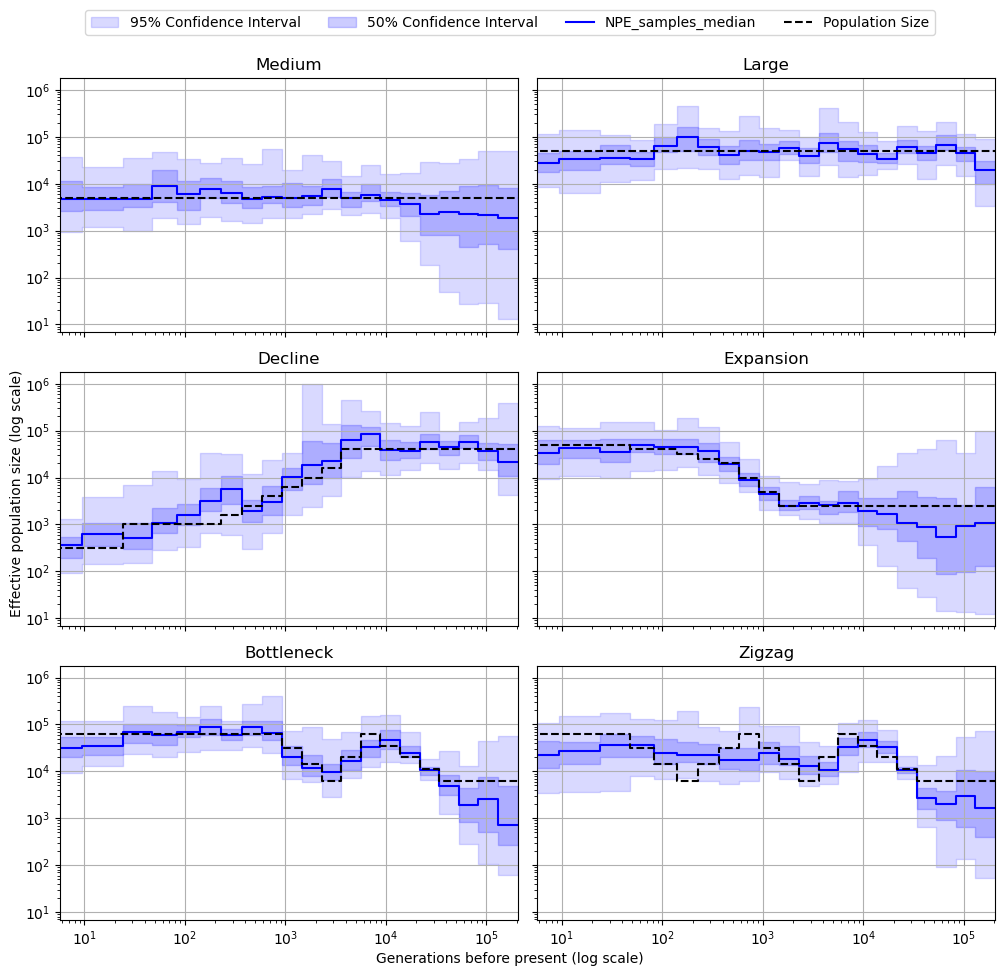

In [14]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex=True, sharey=True)
axs = axs.flatten()

for i, (ax, sce) in enumerate(zip(axs, scenarios)):
    samples = pretrained_posterior.sample((100,), x=sumstats.loc[sce])
    samples = np.exp(samples * train_std.numpy() + train_mean.numpy())
    pred_with_CI(ax, population_time_demo, scenarios[sce], samples)

max_population_time = max(population_time_demo)

# Set the common x-axis limit for all subplots
for ax,sce in zip(axs, scenarios):
    ax.set_xlim(0,max_population_time)
    ax.set_title(sce)

# Collect legend handles and labels from the first axis
handles, labels = axs[0].get_legend_handles_labels()

# Create a single legend for the entire figure
fig.legend(handles, labels,loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=4)

# Set global x and y labels
fig.text(0.5, 0.03, 'Generations before present (log scale)', ha='center')
fig.text(0.0001, 0.5, 'Effective population size (log scale)', va='center', rotation='vertical')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the legend and labels
plt.show()

## 5. NN trained with different summary statistics

...

Text(0.5, 0.98, 'AFS')

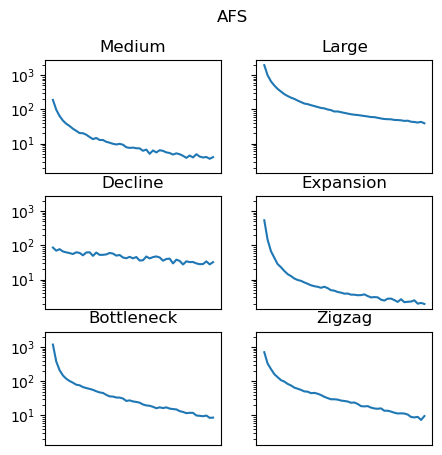

In [15]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(5, 5), sharex=True, sharey=True)
axs = axs.flatten()

for i, (ax, sce) in enumerate(zip(axs, scenarios)):
    ax.plot(sumstats.iloc[:,:-19].loc[sce])
    ax.set_yscale('log')
    ax.set_xticks([])
    ax.set_title(sce)
fig.suptitle('AFS')

Text(0.5, 0.98, 'LD')

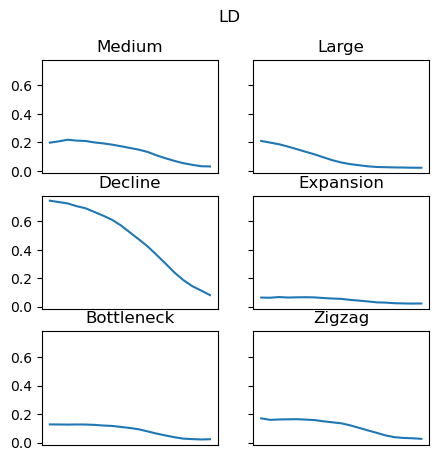

In [16]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(5, 5), sharex=True, sharey=True)
axs = axs.flatten()

for i, (ax, sce) in enumerate(zip(axs, scenarios)):
    ax.plot(sumstats.iloc[:,-19:].loc[sce])
    ax.set_xticks([])
    ax.set_title(sce)
fig.suptitle('LD')

In [17]:
posterior_AFS_path = 'trained_NN/posterior_AFS.pkl'
with open(posterior_AFS_path, 'rb') as f:
    pretrained_AFS_posterior = pickle.load(f)

posterior_LD_path = 'trained_NN/posterior_LD.pkl'
with open(posterior_LD_path, 'rb') as f:
    pretrained_LD_posterior = pickle.load(f)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_40106/497698638.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,max_population_time)


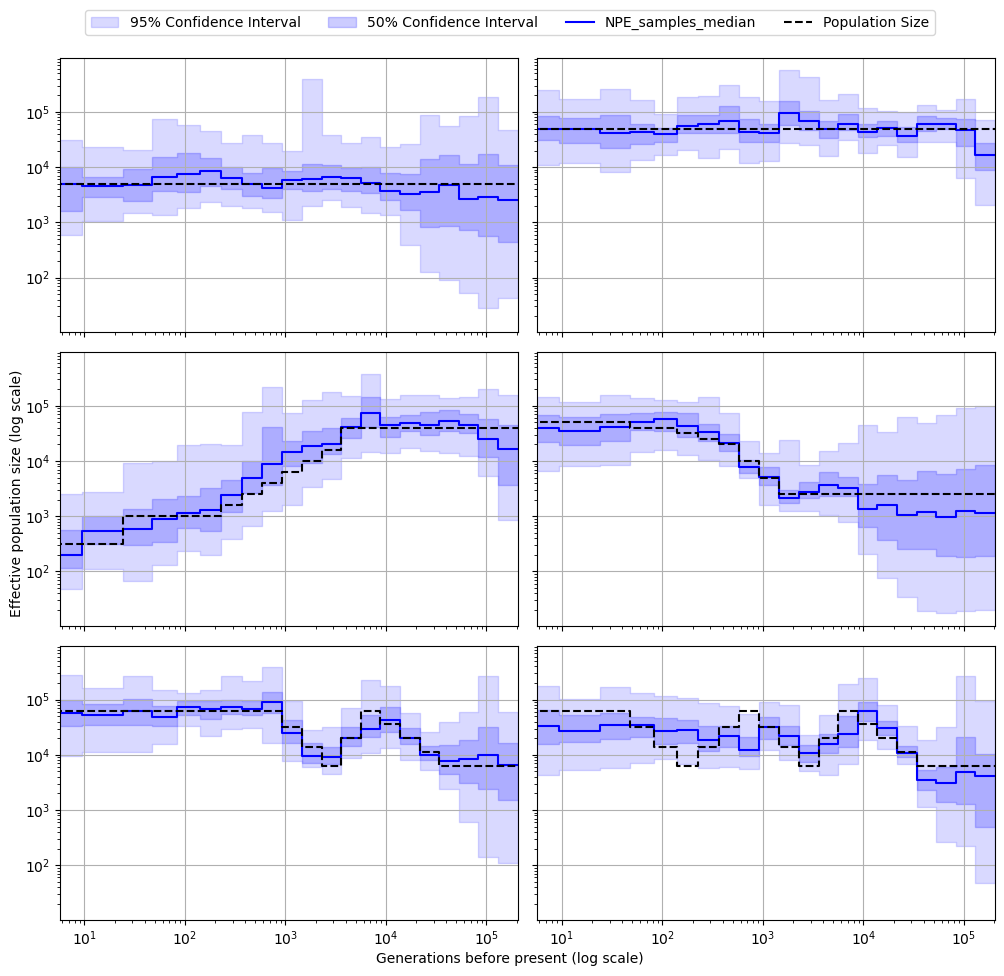

In [18]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex=True, sharey=True)
axs = axs.flatten()

for i, (ax, sce) in enumerate(zip(axs, scenarios)):
    samples = pretrained_AFS_posterior.sample((100,), x=sumstats.iloc[:,:-19].loc[sce])
    samples = np.exp(samples * train_std.numpy() + train_mean.numpy())
    pred_with_CI(ax, population_time_demo, scenarios[sce], samples)

max_population_time = max(population_time_demo)

# Set the common x-axis limit for all subplots
for ax in axs:
    ax.set_xlim(0,max_population_time)

# Collect legend handles and labels from the first axis
handles, labels = axs[0].get_legend_handles_labels()

# Create a single legend for the entire figure
fig.legend(handles, labels,loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=4)

# Set global x and y labels
fig.text(0.5, 0.03, 'Generations before present (log scale)', ha='center')
fig.text(0.0001, 0.5, 'Effective population size (log scale)', va='center', rotation='vertical')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the legend and labels
plt.show()

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_40106/99902422.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,max_population_time)


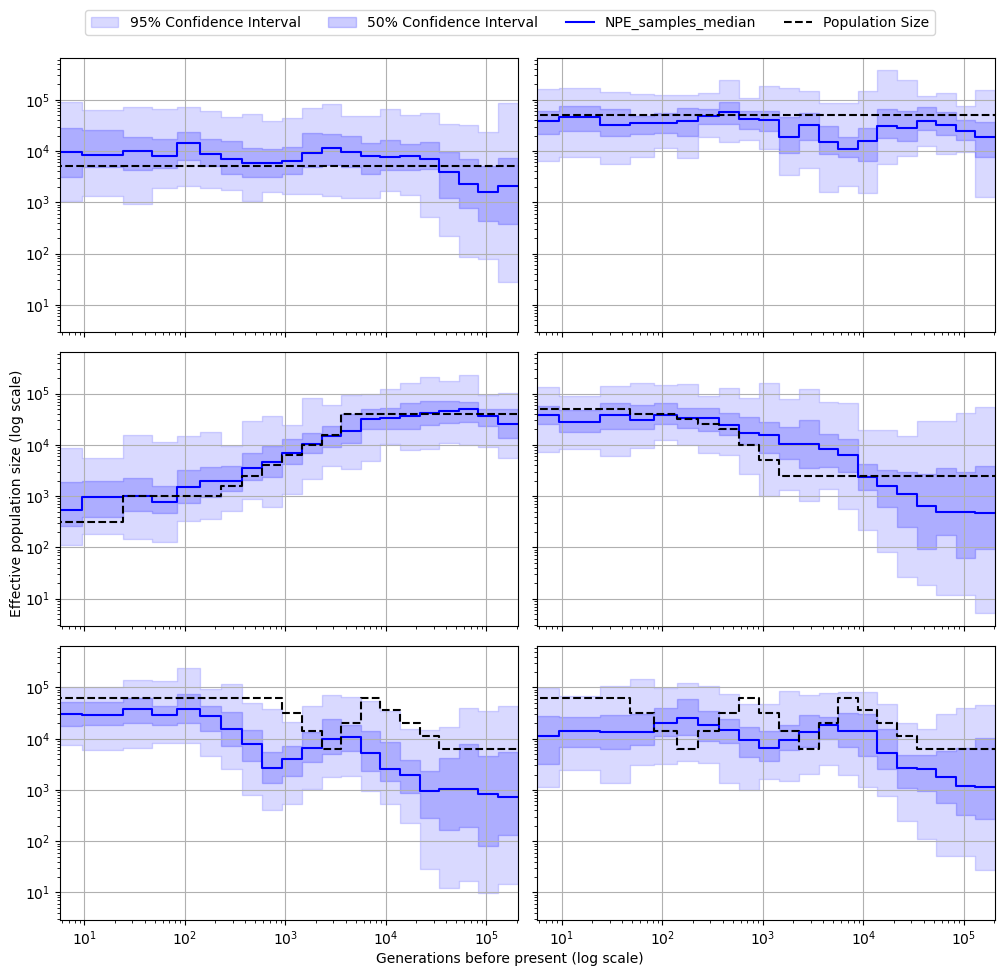

In [19]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex=True, sharey=True)
axs = axs.flatten()

for i, (ax, sce) in enumerate(zip(axs, scenarios)):
    samples = pretrained_LD_posterior.sample((100,), x=sumstats.iloc[:,-19:].loc[sce])
    samples = np.exp(samples * train_std.numpy() + train_mean.numpy())
    pred_with_CI(ax, population_time_demo, scenarios[sce], samples)

max_population_time = max(population_time_demo)

# Set the common x-axis limit for all subplots
for ax in axs:
    ax.set_xlim(0,max_population_time)

# Collect legend handles and labels from the first axis
handles, labels = axs[0].get_legend_handles_labels()

# Create a single legend for the entire figure
fig.legend(handles, labels,loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=4)

# Set global x and y labels
fig.text(0.5, 0.03, 'Generations before present (log scale)', ha='center')
fig.text(0.0001, 0.5, 'Effective population size (log scale)', va='center', rotation='vertical')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the legend and labels
plt.show()

Thank you for following along! We hope this tutorial helps you get started with using NPE for inferring population size histories :)
However, it should be noted that 

---

## 6. A snakemake workflow for more fancy applications

We're currently collaborating with Andrew Kern's lab. The new pipeline will provide three different workflows: an amortized msprime workflow, an amortized dadi workflow, and a sequential msprime workflow. Configuration files control the number of simulations, model details, and training settings, making the workflow flexible for various population genetic scenarios and enabling the usage of existing embedding networks and summary statistics from the literature. However, adding your own custom simulator or embedding network is also easy.